In [2]:
import pandas as pd
from itertools import product

In [3]:
df = pd.read_csv("data/cars-pivot.csv")
df.head()

,STM,Month,Day,0,1,2,3,4,5,6,...,15,16,17,18,19,20,21,22,23,SUMA
0,2,1,Weekend,5.516129,4.258065,2.935484,2.580645,1.516129,5.064516,6.354839,...,46.548387,41.870968,45.064516,40.096774,38.258065,27.000000,16.290323,12.225806,5.677419,SUMA1
1,2,1,Workday,2.112903,1.096774,0.725806,0.532258,0.532258,7.370968,11.580645,...,73.000000,61.790323,68.725806,54.209677,41.451613,27.741935,16.693548,15.225806,5.919355,SUMA1
2,2,2,Weekend,5.807692,4.346154,3.500000,2.923077,2.076923,4.923077,5.961538,...,45.615385,38.846154,41.615385,39.884615,33.000000,22.115385,15.846154,11.461538,6.269231,SUMA1
3,2,2,Workday,2.372881,1.627119,0.728814,0.661017,0.661017,7.322034,11.542373,...,69.677966,62.186441,68.033898,55.135593,41.338983,29.576271,17.610169,14.830508,6.101695,SUMA1
4,2,3,Weekend,7.307692,4.689655,3.217391,2.807692,1.692308,6.038462,7.846154,...,55.423077,45.384615,43.461538,40.423077,40.192308,28.500000,18.576923,11.538462,7.307692,SUMA1


# Sum of mean

Compute a weighted score, which is a sum of absolute deviation from the baseline.

In [4]:
def sum_of_mean(df, stm, day, direction):
    cols = [i for i in range(24)]
    tmp = pd.Series(index=cols, dtype='float64')
    for col in cols:
        # get the mean of 4 (base) lowest values for each hour
        baseline = df[str(col)].sort_values()[:4].mean()
        # compute a sum of absolute values per hour
        # absolute, because you want to consider interesting negatives
        # sum is the final score (interestingness of the hour)
        hour_weight = sum(df[str(col)])/sum(df.sum(axis=1)) if sum(df.sum(axis=1)) else 0
        # weight by relative hour traffic (to discount small increases)
        tmp[col] = ((df[str(col)] - baseline) / baseline).abs().sum() * hour_weight if \
                    baseline else 0
    tmp['Max'] = max(tmp)
    tmp['STM'] = stm
    tmp['Day'] = day
    tmp['SUMA'] = direction
    # return computed Series
    return tmp

In [5]:
som = pd.DataFrame()
for stm, day, direction in list(product(set(df['STM'].values), 
                                            set(df['Day'].values), 
                                            set(df['SUMA'].values))):
    subset = df[(df['STM'] == stm) & (df['Day'] == day) & (df['SUMA'] == direction)]
    som = som.append(sum_of_mean(subset, stm, day, direction), ignore_index=True)

In [6]:
print("Top 10 counter by the sum of mean deviation.")
som.sort_values(by='Max', ascending=False).head(10)['STM']

Top 10 counter by the sum of mean deviation.


581     197.0
582     197.0
583     197.0
580     197.0
1471    504.0
1411    474.0
654     220.0
1895    673.0
2042    734.0
1462    502.0
Name: STM, dtype: float64

In [7]:
def plot_original(df, reference, title):
    stm = reference['STM']
    day = reference['Day']
    direction = reference['SUMA']
    original_subset = df[(df['STM'] == stm) & 
                         (df['Day'] == day) & 
                         (df['SUMA'] == direction)].drop(['STM', 'Day', 'SUMA'], axis=1)
    original_subset.set_index('Month').T.plot(title=f'{title} {stm}')

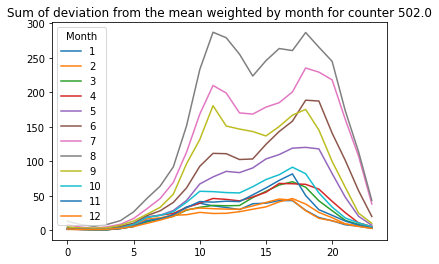

In [8]:
plot_original(df, 
              som.sort_values(by='Max', ascending=False).iloc[9], 
              title="Sum of deviation from the mean weighted by month for counter")

# Coefficient of variation

Compute a coefficient of variation, which is a measure of dispersion of the distributions.

In [83]:
def coefficient_of_variation(df, stm, day, direction):
    cols = [i for i in range(24)]
    tmp = pd.Series(index=cols, dtype='float64')
    for col in cols:
        # get the mean of 4 (base) lowest values for each hour
        mean = df[str(col)].sort_values()[:4].mean()
        std = df[str(col)].std()
        tmp[col] = 100 * std / mean if mean else 0
    tmp['Max'] = max(tmp)
    tmp['STM'] = stm
    tmp['Day'] = day
    tmp['SUMA'] = direction
    # return computed Series
    return tmp

In [84]:
cov = pd.DataFrame()
for stm, day, direction in list(product(set(df['STM'].values), 
                                        set(df['Day'].values), 
                                        set(df['SUMA'].values))):
    subset = df[(df['STM'] == stm) & (df['Day'] == day) & (df['SUMA'] == direction)]
    cov = cov.append(coefficient_of_variation(subset, stm, day, direction), ignore_index=True)

In [86]:
print("Top 10 counter by the coefficient of variation.")
cov.sort_values(by='Max', ascending=False).head(10)['STM']

Top 10 counter by the coefficient of variation.


581     197.0
583     197.0
582     197.0
580     197.0
1471    504.0
1411    474.0
475     154.0
451     144.0
450     144.0
1691    615.0
Name: STM, dtype: float64

In [85]:
cov.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,Day,Max,STM,SUMA
0,165.992696,131.735497,49.530479,19.309831,28.539832,11.486455,5.425929,6.377390,13.073240,49.401905,...,76.412817,115.269531,139.784340,135.324984,148.286737,168.965609,Workday,168.965609,2.0,SUMA2
1,77.671971,62.900564,93.641047,122.780823,244.004411,44.029638,67.708518,62.074088,49.611021,72.268960,...,39.872952,44.647267,51.620814,58.766871,38.594822,56.159187,Workday,244.004411,2.0,SUMA1
2,132.798251,113.915466,104.820263,126.840541,121.732460,74.593216,45.619725,57.905441,71.680846,102.338437,...,150.683989,255.360135,353.982157,385.954600,424.195948,329.702780,Weekend,424.195948,2.0,SUMA2
3,58.140360,66.083927,91.496778,169.493398,395.093493,332.620421,620.506967,380.652779,248.855688,173.341719,...,66.891089,53.070296,59.907052,56.124847,55.965867,64.827880,Weekend,620.506967,2.0,SUMA1
4,34.879563,28.285821,21.770929,12.865799,13.675867,8.541817,6.795653,6.377865,9.249049,8.380703,...,7.301412,10.090584,11.275919,12.121479,8.111035,21.801529,Workday,34.879563,3.0,SUMA2


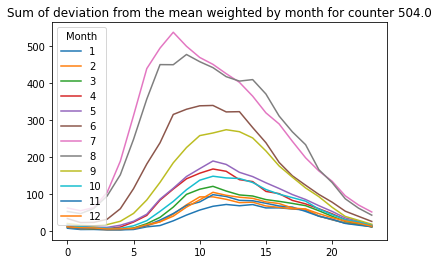

In [87]:
plot_original(df,
              som.sort_values(by='Max', ascending=False).iloc[4],
              title="Coefficient of variation for counter")

# Z Score

Compute z-score, which describes a relationship to the baseline.

In [139]:
def zscore_total(df, stm, day, direction):
    tmp = df.copy(deep=True)
    cols = [str(i) for i in range(24)]
    for col in cols:
        # get the mean of 4 (base) lowest values for each hour
        mean = df[str(col)].sort_values()[:4].mean()
        # compute zscore with the selected baseline
        tmp[str(col)] = (tmp[str(col)] - mean) / tmp[str(col)].std(ddof=0)
    tmp['Max'] = tmp.drop(['STM', 'Month', 'Day', 'SUMA'], axis=1).max(axis=1)
    # return transformed Series
    return tmp

In [140]:
zsco = pd.DataFrame()
for stm, day, direction in list(product(set(df['STM'].values), 
                                        set(df['Day'].values), 
                                        set(df['SUMA'].values))):
    subset = df[(df['STM'] == stm) & (df['Day'] == day) & (df['SUMA'] == direction)]
    zsco = zsco.append(zscore_total(subset, stm, day, direction), ignore_index=True)

In [142]:
print("Top 10 counter by the adjusted z-score.")
zsco.sort_values(by='Max', ascending=False).head(10)['STM']

15969    437
15907    436
7422     206
15981    437
20732    624
29852    907
9157     258
30275    916
12439    348
27899    862
Name: STM, dtype: int64

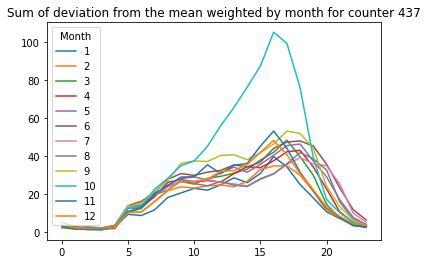

In [143]:
plot_original(df,
              zsco.sort_values(by='Max', ascending=False).iloc[0],
              title="Adjusted z-score for counter")